<a href="https://colab.research.google.com/github/guigomez36/EEA-2022/blob/main/Experimento_Colectivo_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DMEyF/competencia2/competencia2_2022.csv", low_memory=False)


enero = dataset.loc[dataset["foto_mes"]==202101]
marzo = dataset.loc[dataset["foto_mes"]==202103]
mayo = dataset.loc[dataset["foto_mes"]==202105]

In [3]:
mayo['clase_ternaria'].unique()

array([nan], dtype=object)

In [4]:
enero.shape

(161342, 155)

In [5]:
enero=enero.fillna(0) # RELLENO CON 0 LOS NULOS, LO NECESITA LA RED
marzo = marzo.fillna(0)
mayo = mayo.fillna(0)

In [6]:
dataset['foto_mes'].unique()

array([202101, 202102, 202103, 202104, 202105])

In [9]:
# creo clase binaria BAJA+1 y BAJA +2 vs CONTINUA
marzo["clase_binaria"] = marzo["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0) #CLASE COMBINADA
enero["clase_binaria"] = enero["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0)


drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]
X_train = enero[enero.columns.drop( drop)]
y_train = enero["clase_binaria"]
X_test = marzo[marzo.columns.drop(drop)]
y_test = marzo["clase_binaria"]

X_val = mayo[marzo.columns.drop(drop)]

In [11]:
# ESCALADO DE FEATURES
train_max = X_train.max()
train_min = X_train.min()


train_data = (X_train - train_min)/(train_max - train_min)
test_data = (X_test - train_min)/(train_max - train_min)

val_data = (X_val - train_max)/(train_max - train_min)

In [12]:
train_data = tf.cast(train_data, tf.float32) # enero
test_data = tf.cast(test_data, tf.float32) # marzo

In [13]:
train_data.shape

TensorShape([161342, 152])

In [14]:
y_train.shape

(161342,)

Idea: Usar la capa intermedia del AutoEncoder como feature Engineering para un modelo light GBM (LGBM)

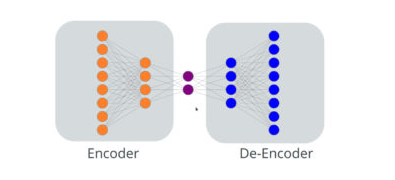

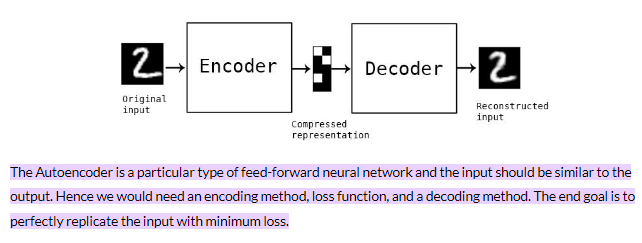

encoder de train_data. dim 152 --> dim 32

In [79]:
from keras.layers import Input,Dense
from keras.models import Model

# number of neurons in the encoding hidden layer
encoding_dim = 64
# input placeholder
input_data = Input(shape=(152,)) # 6 is the number of features/columns
# encoder is the encoded representation of the input
encoded = Dense(encoding_dim, activation ='relu')(input_data)
# decoder is the lossy reconstruction of the input
decoded = Dense(152, activation ='sigmoid')(encoded) # 6 again number of features and should match input_data

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)
# model optimizer and loss
autoencoder = Model(input_data, decoded)

# loss function and optimizer
autoencoder.compile(optimizer='adam', loss='mae')
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train test split
#from sklearn.model_selection import train_test_split
#x_train, x_test, = train_test_split(data, test_size=0.1, random_state=42)


# train the model
history=autoencoder.fit(train_data,
                train_data,
                epochs=10,
                batch_size=256,
                shuffle=True)

autoencoder.summary()

# predict after training
# note that we take them from the *test* set
encoded_data = encoder.predict(train_data)

Epoch 1/10
631/631 [==============================] - 3s 4ms/step - loss: 0.0427
Epoch 2/10
631/631 [==============================] - 2s 4ms/step - loss: 0.0139
Epoch 3/10
631/631 [==============================] - 2s 4ms/step - loss: 0.0125
Epoch 4/10
631/631 [==============================] - 4s 7ms/step - loss: 0.0107
Epoch 5/10
631/631 [==============================] - 3s 5ms/step - loss: 0.0091
Epoch 6/10
631/631 [==============================] - 3s 5ms/step - loss: 0.0077
Epoch 7/10
631/631 [==============================] - 2s 4ms/step - loss: 0.0073
Epoch 8/10
631/631 [==============================] - 2s 4ms/step - loss: 0.0070
Epoch 9/10
631/631 [==============================] - 6s 9ms/step - loss: 0.0068
Epoch 10/10
631/631 [==============================] - 4s 7ms/step - loss: 0.0067
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 15

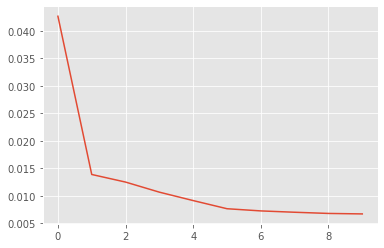

In [80]:
plt.plot(history.history["loss"], label="Training Loss")

agrego la salida del encoder al dataset original como nuevas columnas

In [81]:
#agrego la salida del encoder al dataset original como nuevas columnas

# convert it to tensorflow
#tensor1 = tf.convert_to_tensor(numpy_array)
encoded_data=tf.convert_to_tensor(encoded_data)
encoded_data = tf.cast(encoded_data, tf.float32)
res=tf.concat(axis=1,values=[encoded_data, train_data])

#aplico lightgbm por default en python

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import lightgbm as ltb

#lightgbm
model_train = ltb.LGBMClassifier()
model_train.fit(res, y_train)

#calculo kpis de train (enero)
predicted_y = model_train.predict(res)
print(metrics.classification_report(y_train, predicted_y))
cm_train=metrics.confusion_matrix(y_train, predicted_y)
print(cm_train)

              precision    recall  f1-score   support

           0       0.85      0.24      0.38      1514
           1       0.99      1.00      1.00    159828

    accuracy                           0.99    161342
   macro avg       0.92      0.62      0.69    161342
weighted avg       0.99      0.99      0.99    161342

[[   369   1145]
 [    64 159764]]


entreno con los datos puros sin FE de CNN de dimensionalidad

In [82]:
# dataset de train sin "res" que son los features de la CNN
model_train_sin_res = ltb.LGBMClassifier()
model_train_sin_res.fit(train_data, y_train)

model_train_sin_res.fit(train_data, y_train)
predicted_y1 = model_train_sin_res.predict(train_data)
print(metrics.classification_report(y_train, predicted_y1))
cm_train_sin_res=metrics.confusion_matrix(y_train, predicted_y1)
print(cm_train_sin_res)

              precision    recall  f1-score   support

           0       0.77      0.22      0.34      1514
           1       0.99      1.00      1.00    159828

    accuracy                           0.99    161342
   macro avg       0.88      0.61      0.67    161342
weighted avg       0.99      0.99      0.99    161342

[[   336   1178]
 [   102 159726]]


ahora encode con datos de test

In [83]:
from keras.layers import Input,Dense
from keras.models import Model

# number of neurons in the encoding hidden layer
encoding_dim = 64
# input placeholder
input_data = Input(shape=(152,)) # 6 is the number of features/columns
# encoder is the encoded representation of the input
encoded = Dense(encoding_dim, activation ='relu')(input_data)
# decoder is the lossy reconstruction of the input
decoded = Dense(152, activation ='sigmoid')(encoded) # 6 again number of features and should match input_data

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)
# model optimizer and loss
autoencoder = Model(input_data, decoded)

# loss function and optimizer
autoencoder.compile(optimizer='adam', loss='mae')
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train test split
#from sklearn.model_selection import train_test_split
#x_train, x_test, = train_test_split(data, test_size=0.1, random_state=42)


# train the model
autoencoder.fit(test_data,
                test_data,
                epochs=10,
                batch_size=256,
                shuffle=True)

autoencoder.summary()

# predict after training
# note that we take them from the *test* set
encoded_data = encoder.predict(test_data)

Epoch 1/10
637/637 [==============================] - 3s 5ms/step - loss: 0.0435
Epoch 2/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0131
Epoch 3/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0118
Epoch 4/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0102
Epoch 5/10
637/637 [==============================] - 4s 7ms/step - loss: 0.0079
Epoch 6/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0074
Epoch 7/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0072
Epoch 8/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0071
Epoch 9/10
637/637 [==============================] - 3s 4ms/step - loss: 0.0070
Epoch 10/10
637/637 [==============================] - 3s 5ms/step - loss: 0.0070
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 15

entreno el modelo con el dataset original de test + FE de encoder

In [84]:
encoded_data=tf.convert_to_tensor(encoded_data)
encoded_data = tf.cast(encoded_data, tf.float32)

res=tf.concat(axis=1,values=[encoded_data, test_data])


model_test = ltb.LGBMClassifier()
model_test.fit(res, y_test)


predicted_y_test = model_test.predict(res)
predicted_y_test_proba = model_test.predict_proba(res)

print(metrics.classification_report(y_test, predicted_y_test))

cm_test=metrics.confusion_matrix(y_test, predicted_y_test)
print(cm_test)

#ltb.plot_importance(model_test, max_num_features=10,figsize=(10, 9)) --> se pierde el mapeo de que es cada columna

              precision    recall  f1-score   support

           0       0.74      0.25      0.37      1979
           1       0.99      1.00      0.99    160921

    accuracy                           0.99    162900
   macro avg       0.87      0.62      0.68    162900
weighted avg       0.99      0.99      0.99    162900

[[   496   1483]
 [   172 160749]]


dataset original de test sin FE

In [28]:
model_test_sin_res = ltb.LGBMClassifier()
model_test_sin_res.fit(test_data, y_test)

predicted_y_test_sin_res = model_test_sin_res.predict(test_data)
print(metrics.classification_report(y_test, predicted_y_test_sin_res))

cm_test_sin_res=metrics.confusion_matrix(y_test, predicted_y_test_sin_res)
print(cm_test_sin_res)

              precision    recall  f1-score   support

           0       0.82      0.19      0.31      1979
           1       0.99      1.00      0.99    160921

    accuracy                           0.99    162900
   macro avg       0.91      0.59      0.65    162900
weighted avg       0.99      0.99      0.99    162900

[[   377   1602]
 [    81 160840]]


cuantos envios con p>0.025 considerando BAJA +1 y BAJA +2

In [85]:
c=1
for i in (predicted_y_test_proba):
  #print(i[0])
  if i[0]>0.025:
    c=c+1
print(c)

13587


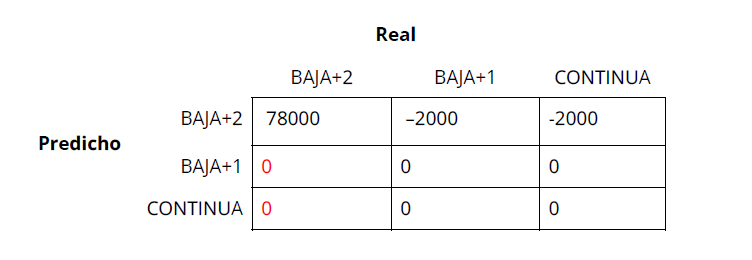

[[   496   1483]

[   172 160749]]

 con FE


In [86]:
78000*496-2000*(1483)

35722000

[[   377   1602]

[    81 160840]]

sin FE

In [87]:
78000*377-2000*(1602)

26202000

prueba de decodificadores




In [73]:
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras.layers import Input,Dense
from keras.models import Model

input_data = Input(shape=(152,))
encoded = Dense(16, activation='relu')(input_data)
#encoded = Dense(32, activation='relu')(encoded)
#encoded = Dense(16, activation='relu')(encoded)

#decoded = Dense(16, activation='relu')(encoded)
#decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)

decoded = Dense(152, activation='sigmoid')(decoded)

encoder=keras.Model(input_data, encoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mae')

# train the model
autoencoder.fit(train_data,
                train_data,
                epochs=10,
                batch_size=256,
                shuffle=True)

autoencoder.summary()

# predict after training
# note that we take them from the *test* set
encoded_data = encoder.predict(train_data)

# le aplico al encoded_data un arbol lgbm

encoded_data=tf.convert_to_tensor(encoded_data)
encoded_data = tf.cast(encoded_data, tf.float32)

#add FE to dataset train
res=tf.concat(axis=1,values=[encoded_data, train_data])

#lgbm
model = ltb.LGBMClassifier()
model.fit(res, y_train)

predicted_y = model.predict(res)
print(metrics.classification_report(y_train, predicted_y))
cm=metrics.confusion_matrix(y_train, predicted_y)
print(cm)

Epoch 1/10
631/631 [==============================] - 3s 4ms/step - loss: 0.0556
Epoch 2/10
631/631 [==============================] - 2s 4ms/step - loss: 0.0156
Epoch 3/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0148
Epoch 4/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0145
Epoch 5/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0143
Epoch 6/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0140
Epoch 7/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0139
Epoch 8/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0136
Epoch 9/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0132
Epoch 10/10
631/631 [==============================] - 2s 3ms/step - loss: 0.0128
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 15

In [74]:
encoded_data.shape

TensorShape([161342, 16])